In [1]:
import pyro
import pyro.distributions                                       as dist
from pyro.distributions                                         import MultivariateNormal, Beta, Categorical, InverseGamma, Gamma, Delta
from pyro.distributions                                         import Exponential, TransformedDistribution, Uniform, Dirichlet, VonMises
from pyro.infer                                                 import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro                                                       import poutine
from pyro.distributions.torch_distribution                      import TorchDistribution
from pyro.nn                                                    import PyroModule, PyroParam, PyroSample
from pyro.distributions.torch_transform                         import TransformModule
from torch.distributions                                        import constraints

import torch
import torch.nn                                                 as nn
import torch.nn.functional                                      as F

import numpy                                                    as np
import matplotlib.pyplot                                        as plt
import pathlib
import os

from stiefel                                                    import Circular
from utils                                                      import mix_weights
from test_utils                                                 import PostPred, show_mix
from test_utils_map                                             import PostPredMap, show_mix_map, PostPredPre, show_mix_pre

/home/lz1919/anaconda3/envs/menv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Run the file `run_mean_field.py` setting the necessary hyperparameters and data (2D `torch.tensor`), which we want to learn the density of, and uncomment all the `NOTE` code to save the training data.

Then run the code below to plot the posterior predictive samples from the posterior given by the MAP estimates, pre-trained normalising flow and the final variational posterior. The function `show_mix` also plots realisations of the learned clusters from the final variational posterior.

In [2]:
cwd = pathlib.Path(os.getcwd())
experiments_path = cwd / "20:09:2023_17:44:57"  # set as folder containing training data

data = np.genfromtxt(cwd / "spiral_2D_delta_01_data.csv", delimiter="", encoding=None)
data = torch.from_numpy(data).float()

In [3]:
def load_model(experiments_path, data):
    """
    For run_mean_field_map.py
    """

    losses = torch.load(experiments_path / "losses.pt")
    map_losses = torch.load(experiments_path / "map_losses.pt")
    pretrain_losses = torch.load(experiments_path / "pretrain_losses.pt")

    # extract normalising flows
    flow_parms = torch.load(experiments_path / "flow_params.pt")
    map_init = torch.load(experiments_path / "map_init.pt")

    # extract variational parameters
    kappa_1 = torch.load(experiments_path / "kappa_1.pt")
    kappa_2 = torch.load(experiments_path / "kappa_2.pt")
    gamma_1 = torch.load(experiments_path / "gamma_1.pt")
    gamma_2 = torch.load(experiments_path / "gamma_2.pt")
    delta_1 = torch.load(experiments_path / "delta_1.pt")
    delta_2 = torch.load(experiments_path / "delta_2.pt")
    tau = torch.load(experiments_path / "tau.pt")
    sigma = torch.load(experiments_path / "sigma.pt")
    phi = torch.load(experiments_path / "phi.pt")

    ndim = data.shape[-1]
    stiefel_dim = ndim * (ndim - 1) // 2
    T = len(tau)

    # pre-training flow
    pre_flows = nn.ModuleList([Circular(num_input_channels=stiefel_dim,
                                    context_features=T,
                                    **flow_parms) for _ in range(flow_parms["num_trans"])])
    pre_flows.load_state_dict(torch.load(experiments_path / "pre_flows.pt"))
    pre_flows.eval()

    # VI flow
    flows = nn.ModuleList([Circular(num_input_channels=stiefel_dim,
                                    context_features=T,
                                    **flow_parms) for _ in range(flow_parms["num_trans"])])
    flows.load_state_dict(torch.load(experiments_path / "flows.pt"))
    flows.eval()

    return losses, map_losses, pretrain_losses, kappa_1, kappa_2, gamma_1, gamma_2, delta_1, \
           delta_2, tau, sigma, list(pre_flows), list(flows), phi, map_init, T

In [4]:
losses, map_losses, pretrain_losses, kappa_1, kappa_2, gamma_1, gamma_2, delta_1, \
delta_2, tau, sigma, pre_flows, flows, phi, map_init, T = load_model(experiments_path, data)

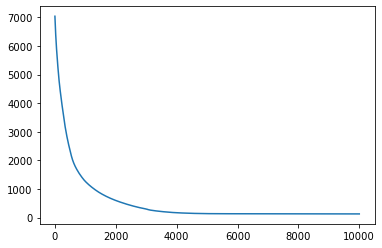

In [5]:
# plot loss curve for MAP estimation
plt.plot(map_losses)

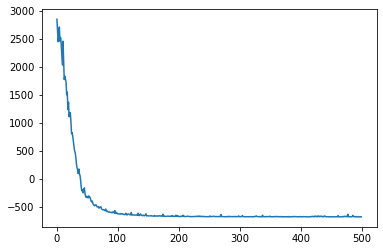

In [6]:
# plot loss curve for pre-training
plt.plot(pretrain_losses)

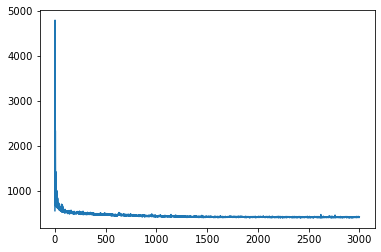

In [7]:
# plot loss curve for variational inference
plt.plot(losses)

In [8]:
postpredmap = PostPredMap(map_init["mu"], map_init["theta"], map_init["beta"], map_init["lamb"])
obs_map = postpredmap.sample(len(data))

(-1.7340148091316223,
 2.1537535786628723,
 -1.9950530648231506,
 1.4836797833442688)

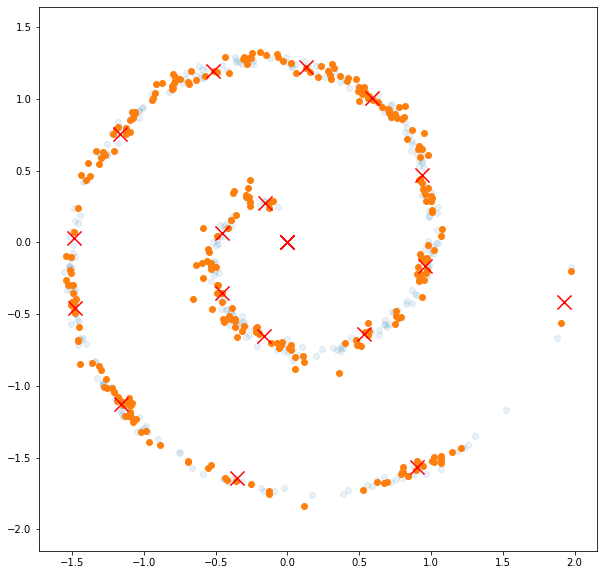

In [9]:
# plot of data with posterior predictive samples from MAP estimates
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], alpha=0.1)
plt.scatter(obs_map[:, 0], obs_map[:, 1])
plt.scatter(map_init["mu"][:, 0], map_init["mu"][:, 1], color='red', marker='x', s=200)  # MAP mu locations
plt.axis("equal")

In [10]:
prepred = PostPredPre(map_init["mu"], map_init["beta"], map_init["lamb"], pre_flows)
obs_pre = prepred.sample(len(data))

(-1.7435525953769684,
 2.151201754808426,
 -1.916262137889862,
 1.4610435843467713)

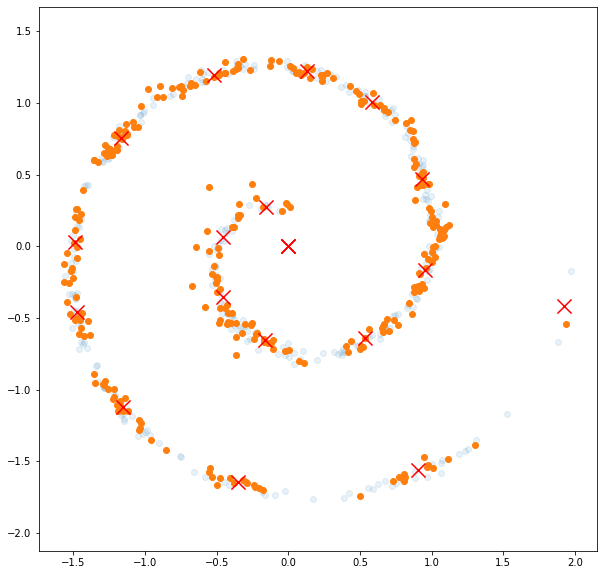

In [11]:
# plot of data with posterior predictive samples from pre-training estimates
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], alpha=0.1)
plt.scatter(obs_pre[:, 0], obs_pre[:, 1])
plt.scatter(map_init["mu"][:, 0], map_init["mu"][:, 1], color='red', marker='x', s=200)  # MAP mu locations
plt.axis("equal")

In [12]:
postpred = PostPred(kappa_1, kappa_2, gamma_1, gamma_2, tau, sigma, flows, phi)
obs = postpred.sample(len(data))

(-1.7786291658878326,
 2.152872067689896,
 -2.0054610431194306,
 1.5068659245967866)

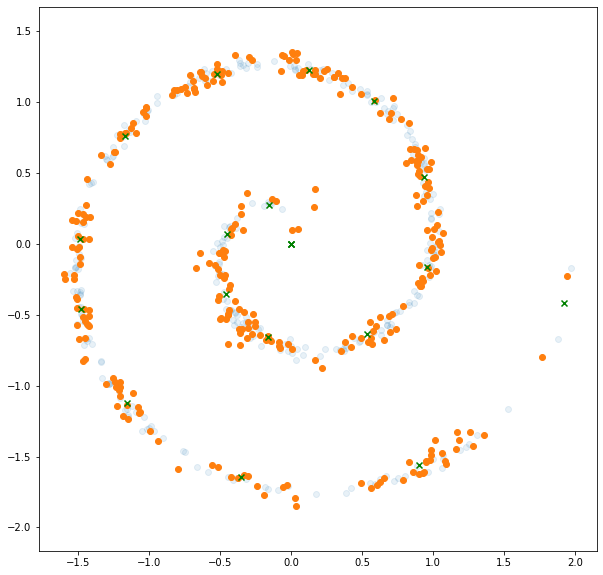

In [13]:
# # plot of data with posterior predictive samples from variational inference posterior 
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], alpha=0.1)
plt.scatter(obs[:, 0], obs[:, 1])
plt.scatter(tau.detach()[:, 0], tau.detach()[:, 1], color='green', marker='x')  # mu locations from variational parameters
plt.axis("equal")

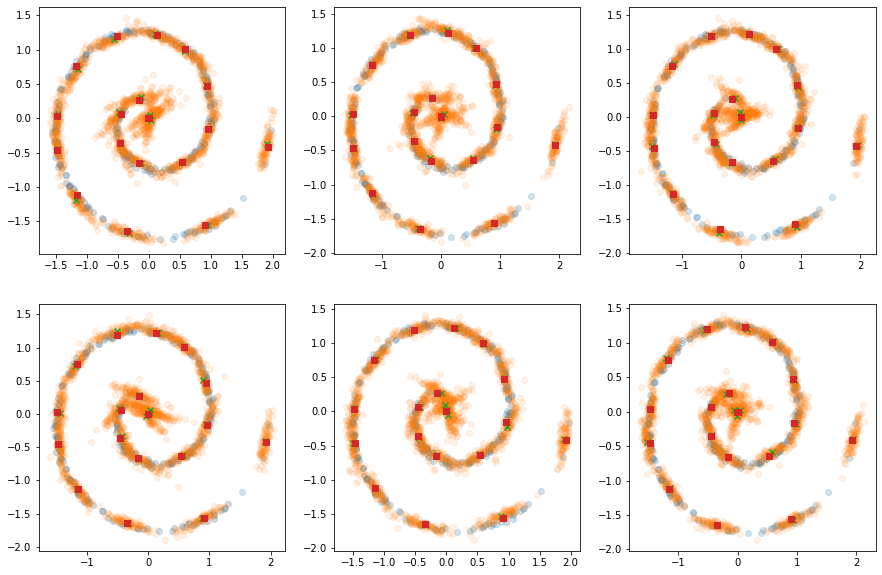

In [14]:
# show realisations of the kth mixture cluster distribution via samples - set k=None to show all clusters
k = None
show_mix(data, postpred, tau, k=k)